## Problem 2. Train a machine learning model using the training file to predict the values of the ‘tat_in_days’ column for the test file. ( Evaluation on the basis on RMSE score)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import svm
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Loading Training Data

In [2]:
df = pd.read_csv("problem_2_train.csv")

In [3]:
df.head()

,srno,mobmake,hubid,hubpincode,pickuppartnerid,deliverypartnerid,insuranceCompanyId,custpincodecategory,claimtype,custpincode,memcreateddate,mobilepurchasedate,claimintdate,servicecntrid,pickupStartdate,tat_in_days
0,2851218,AN,7,500004,233,233,131,A,ADLD,500001,2017-04-27,2016-12-02,2018-02-08,4403,2018-02-13,5
1,2838330,AJ,10,226010,233,233,131,A,ADLD,226022,2017-03-06,2017-03-05,2018-02-04,4444,2018-02-08,12
2,2835781,AJ,2,110018,233,233,228,A,ADLD,110018,2018-02-01,2018-01-27,2018-02-03,4388,2018-02-12,9
3,2838589,AM,2,110018,233,233,228,B,ADLD,124001,2018-01-17,2018-01-31,2018-02-04,4092,2018-02-14,9
4,2855214,AN,21,110015,233,233,131,A,ADLD,201301,2018-01-23,2018-01-20,2018-02-09,4580,2018-02-14,8


In [4]:
df.describe()

,srno,hubid,hubpincode,pickuppartnerid,deliverypartnerid,insuranceCompanyId,custpincode,servicecntrid,tat_in_days
count,6.250000e+03,6250.000000,6250.000000,6250.000000,6250.000000,6250.000000,6250.000000,6250.000000,6250.000000
mean,2.946134e+06,11.732000,340546.139840,232.654400,231.495360,155.040480,366009.473440,4457.158080,12.730400
std,7.733480e+04,9.141463,213449.097822,30.471658,22.521945,41.883918,210990.167946,200.945634,5.075533
min,2.818359e+06,0.000000,0.000000,0.000000,0.000000,131.000000,0.000000,4008.000000,2.000000
25%,2.877226e+06,3.000000,110018.000000,233.000000,233.000000,131.000000,135034.000000,4398.000000,9.000000
50%,2.944426e+06,8.000000,400001.000000,233.000000,233.000000,131.000000,395001.500000,4474.000000,12.000000
75%,3.012237e+06,21.000000,500004.000000,233.000000,233.000000,131.000000,560016.000000,4580.000000,15.000000
max,3.101035e+06,27.000000,800001.000000,308.000000,245.000000,228.000000,855107.000000,5146.000000,57.000000


### Encoding str columns 

In [5]:
le = LabelEncoder()
cols = ['claimtype']
df[cols] = df[cols].apply(lambda c: le.fit_transform(c))

### Adding a new Column `delay` - difference of claim date and pickup date

In [6]:
df.pickupStartdate = pd.to_datetime(df['pickupStartdate'])
df.claimintdate = pd.to_datetime(df['claimintdate'])

df['delay'] = (df.pickupStartdate-df.claimintdate).dt.days

### Heatmap showing correlation between different features

#### Observation - High correlation between hub pin code and cust pin code

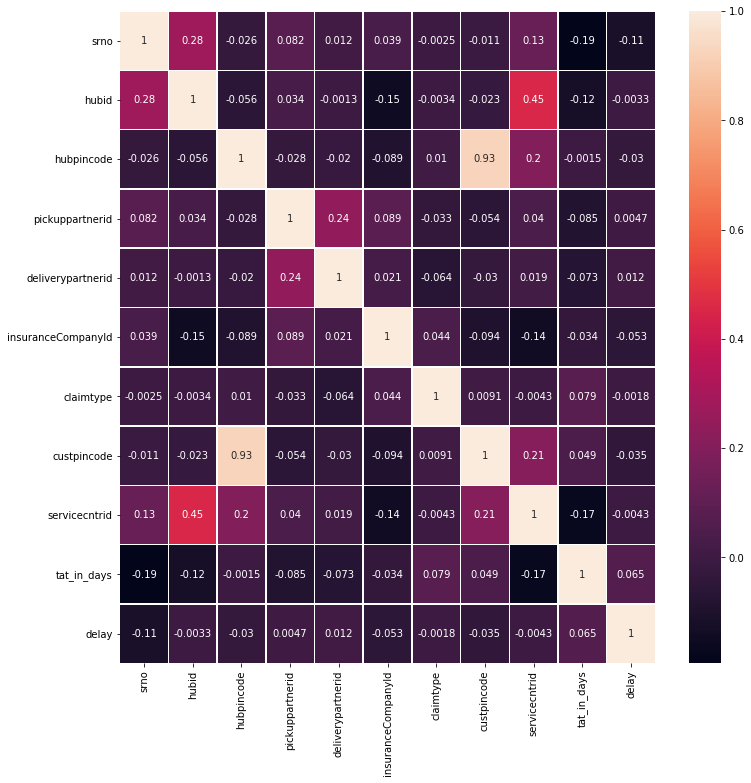

In [7]:
corr_matrix=df.corr()
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corr_matrix,annot=True,linewidths=.5, ax=ax)

### Droping columns deemed as useless

In [8]:
df.drop(['srno','claimintdate','pickupStartdate','memcreateddate','mobilepurchasedate','mobmake','custpincodecategory'],inplace = True,axis = 1)
# df.drop(['srno','claimintdate','pickupStartdate','memcreateddate','mobilepurchasedate','custpincode','hubpincode','pickuppartnerid','deliverypartnerid'],inplace = True,axis = 1)

In [9]:
#X = df[['mobmake','pickuppartnerid','servicecntrid','hubid']]

In [10]:
columns = df.columns
columns = list(columns)
columns.remove('tat_in_days')
print(columns)

['hubid', 'hubpincode', 'pickuppartnerid', 'deliverypartnerid', 'insuranceCompanyId', 'claimtype', 'custpincode', 'servicecntrid', 'delay']


In [11]:
X = df.loc[:,columns]
y = df.loc[:,'tat_in_days']
X.shape,y.shape

((6250, 9), (6250,))

### Splitting data into test train

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X, y,test_size = 0.3)

### Checking Few Models based on rms value

In [13]:
def checkmodel(x_train,y_train,x_test,y_test):
    scaler = StandardScaler()
    #scaler =  QuantileTransformer(output_distribution='normal')
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    clf = LinearRegression()
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    print("Linear Regressor: ",np.sqrt(mean_squared_error(y_pred,y_test)))
    clf = svm.SVR(C=2.5,kernel='rbf',gamma = 'scale')
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    print("SVM: ", np.sqrt(mean_squared_error(y_pred,y_test)))
    clf = XGBRegressor()
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    print("XGBoost: ",np.sqrt(mean_squared_error(y_pred,y_test)))
    clf = GradientBoostingRegressor()
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    print("GBR: ",np.sqrt(mean_squared_error(y_pred,y_test)))

In [14]:
checkmodel(x_train,y_train,x_test,y_test)

Linear Regressor:  5.088880971549578
SVM:  4.984342881641655
[14:25:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost:  4.715343589686906
GBR:  4.704373409986178


### Pipeline architecture to test various models based on Mean Square values and - different scaling techniques

In [26]:
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
pipelines.append(('ScaledXGB', Pipeline([('Scaler', StandardScaler()),('XGB', XGBRegressor())])))
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=21)
    cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: -23.158342 (1.950779)
ScaledLASSO: -24.871378 (2.288456)
ScaledEN: -24.500974 (2.210196)
ScaledKNN: -23.174477 (2.678126)
ScaledCART: -36.275244 (2.542162)
ScaledGBM: -19.562603 (2.347955)
[14:27:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of

In [27]:
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', MinMaxScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', MinMaxScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', MinMaxScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', MinMaxScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', MinMaxScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', MinMaxScaler()),('GBM', GradientBoostingRegressor())])))
pipelines.append(('ScaledXGB', Pipeline([('Scaler', MinMaxScaler()),('XGB', XGBRegressor())])))


results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=21)
    cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: -23.158342 (1.950779)
ScaledLASSO: -24.871378 (2.288456)
ScaledEN: -24.871378 (2.288456)
ScaledKNN: -22.898185 (2.624166)
ScaledCART: -36.444051 (2.642857)
ScaledGBM: -19.556502 (2.340248)
[14:27:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:27:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of

### HyperParameter tuning for XGBoost using GridSearch

In [17]:
# # for tuning parameters
# parameters_for_testing = {
#    'colsample_bytree':[0.4,0.6,0.8],
#    'gamma':[0,0.03,0.1,0.3],
#    'min_child_weight':[1.5,6,10],
#    'learning_rate':[0.1,0.07],
#    'max_depth':[3,5],
#    'n_estimators':[1000],
#    'reg_alpha':[1e-5, 1e-2,  0.75],
#    'reg_lambda':[1e-5, 1e-2, 0.45],
#    'subsample':[0.6,0.95]  
# }

                    
# xgb_model = XGBRegressor(learning_rate =0.1, n_estimators=1000, max_depth=5,
#     min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=27)

# gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, n_jobs=6,iid=False, verbose=10,scoring='neg_mean_squared_error')
# gsearch1.fit(x_train,y_train)
# print (gsearch1.grid_scores_)
# print('best params')
# print (gsearch1.best_params_)
# print('best score')
# print (gsearch1.best_score_)

### Loading Test Data

In [18]:
df_test = pd.read_csv("problem_2_test.csv")

In [19]:
df_test[cols] = df_test[cols].apply(lambda c: le.transform(c))

In [20]:
df_test.drop(['srno','claimintdate','pickupStartdate','memcreateddate','mobilepurchasedate','mobmake','custpincodecategory'],inplace = True,axis = 1)


### Scaling Data

In [21]:
scaler = StandardScaler()

X = scaler.fit_transform(X)
xx = scaler.transform(df_test.loc[:,columns])

### Prediction using XGBoost

In [22]:
clf = XGBRegressor() 
clf.fit(X,y)
yp = clf.predict(xx)

[14:25:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


### Saving Data

In [28]:
np.savetxt("predict-problem-2.csv",yp,delimiter=",", fmt ="%.6f")